                                                text  target  \
0  \n\nI am sure some bashers of Pens fans are pr...      10   
1  My brother is in the market for a high-perform...       3   
2  \n\n\n\n\tFinally you said what you dream abou...      17   
3  \nThink!\n\nIt's the SCSI card doing the DMA t...       3   
4  1)    I have an old Jasmine drive which I cann...       4   

                   category  
0          rec.sport.hockey  
1  comp.sys.ibm.pc.hardware  
2     talk.politics.mideast  
3  comp.sys.ibm.pc.hardware  
4     comp.sys.mac.hardware  
Columns: ['text', 'target', 'category']
Using text column 'text' and label column 'target'
Loaded 18846 documents, 20 labels


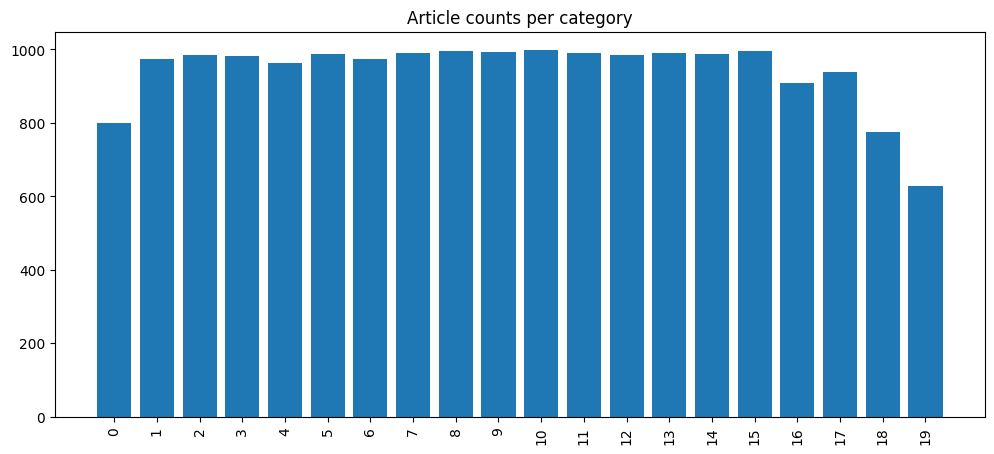

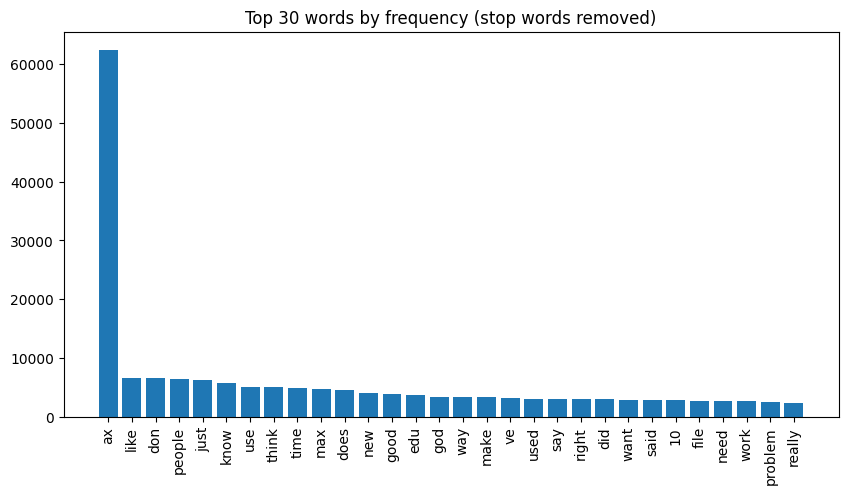

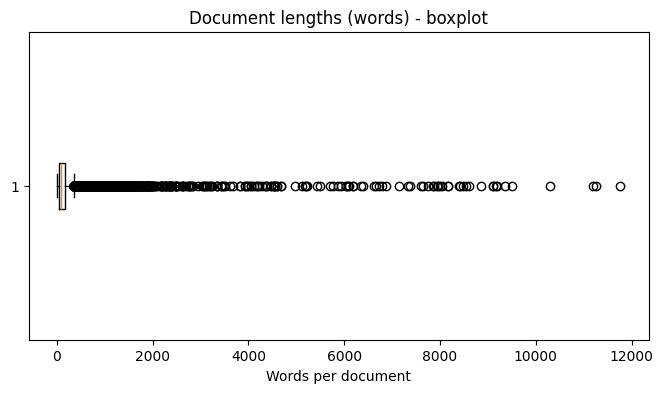

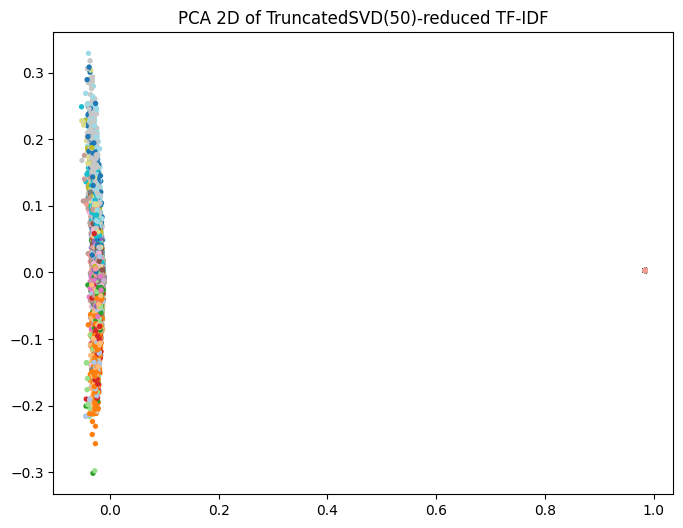

Unigram baseline: 0.7564986737400531 0.7490827599140029
1-3 grams result: 0.7681697612732096 0.7599393806603771
Count features before chi2 selection: 31726
Chi2 k=5000 -> acc=0.7074, macro_f1=0.6988
Chi2 k=2000 -> acc=0.6655, macro_f1=0.6559


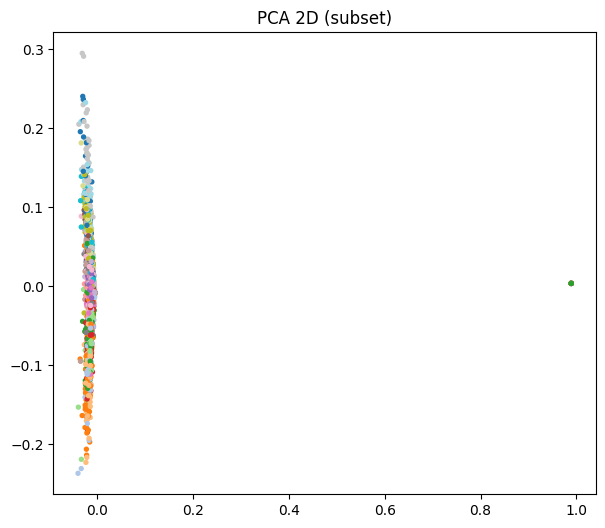

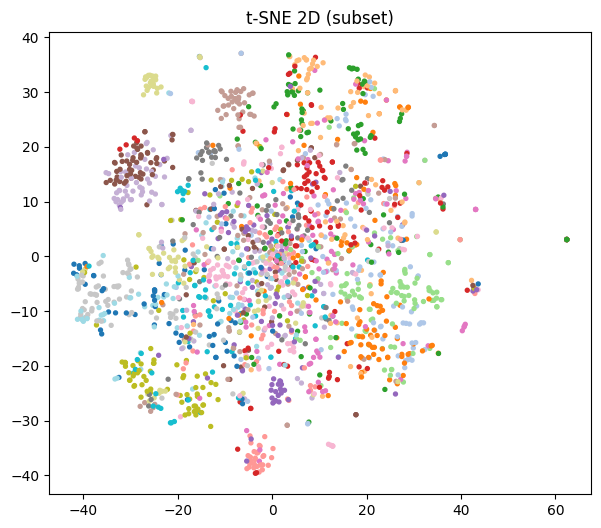

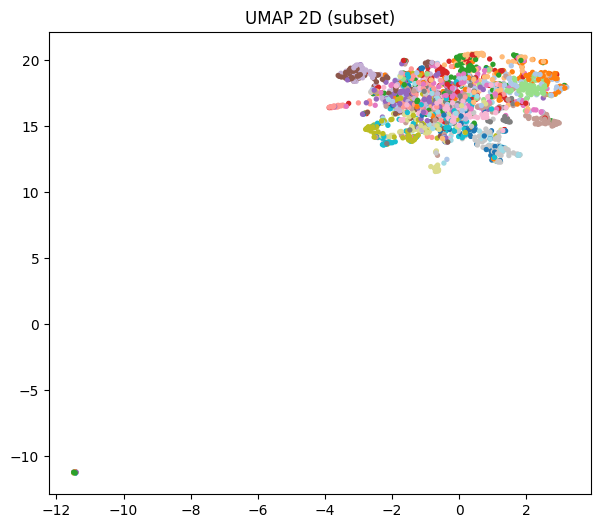

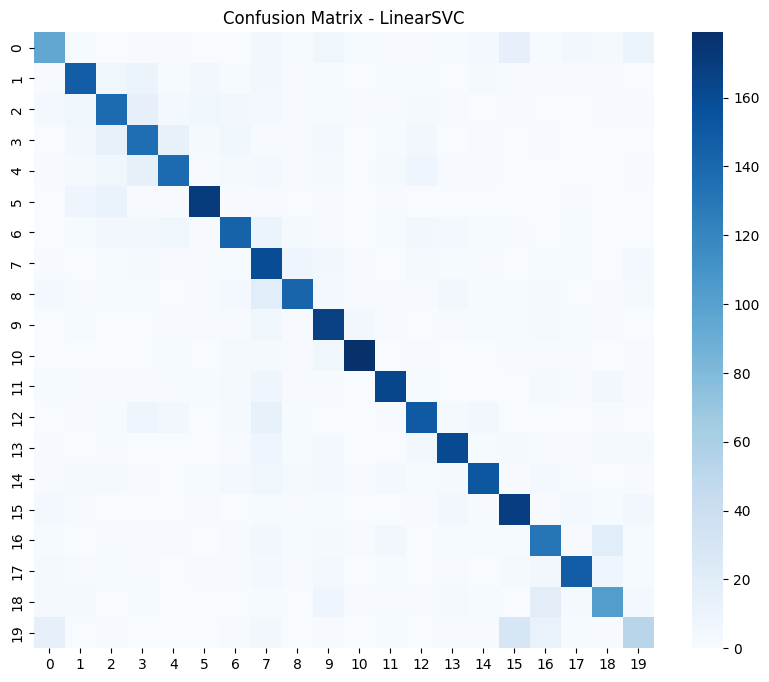

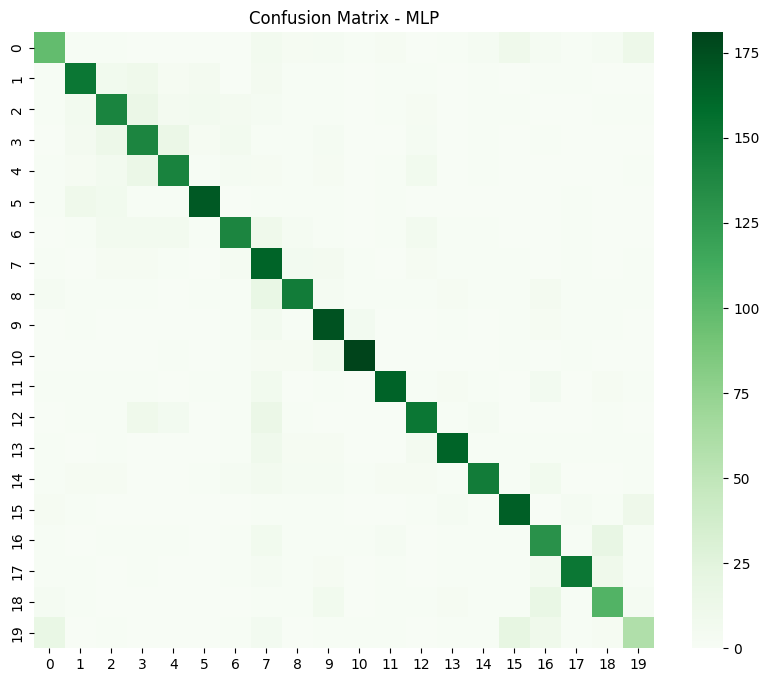

In [ ]:
# news_20newsgroups_pipeline_inline.py
# Full pipeline for News Article Categorization with inline results

import time, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Optional UMAP
try:
    import umap.umap_ as umap
    HAVE_UMAP = True
except Exception:
    HAVE_UMAP = False

# ----------------- Config -----------------
EXCEL_PATH = "20_newsgroups_manual.xls"
RANDOM_STATE = 42

# ----------------- Load dataset -----------------
df = pd.read_csv("20_newsgroups_manual.xls")
print(df.head())
 # Excel file
print("Columns:", df.columns.tolist())

# heuristics to find text and label columns
possible_text_cols = [c for c in df.columns if any(k in c.lower() for k in ['text','content','article','body','message'])]
possible_label_cols = [c for c in df.columns if any(k in c.lower() for k in ['label','target','category','class'])]
if not possible_text_cols or not possible_label_cols:
    raise RuntimeError("Could not auto-detect text/label columns. Columns: " + str(df.columns.tolist()))

text_col = possible_text_cols[0]
label_col = possible_label_cols[0]
print(f"Using text column '{text_col}' and label column '{label_col}'")

df = df[[text_col, label_col]].rename(columns={text_col: "text", label_col: "label"})
df['text'] = df['text'].astype(str)

# encode labels if they are strings
if df['label'].dtype == object or df['label'].dtype == str:
    label_values = sorted(df['label'].unique())
    label_map = {lab: idx for idx, lab in enumerate(label_values)}
    df['label_id'] = df['label'].map(label_map)
    target_names = label_values
else:
    df['label_id'] = df['label'].astype(int)
    target_names = sorted(df['label'].unique())

df['doc_len_words'] = df['text'].apply(lambda x: len(x.split()))
print(f"Loaded {len(df)} documents, {len(target_names)} labels")

# ----------------- 1. EDA -----------------
# 1a. Bar chart: article counts per category
counts = df['label_id'].value_counts().sort_index()
plt.figure(figsize=(12,5))
plt.bar(range(len(counts)), counts.values)
plt.xticks(range(len(counts)), target_names, rotation=90)
plt.title("Article counts per category")
plt.show()

# 1b. Word frequency histograms (top 30 words)
cv = CountVectorizer(stop_words='english', max_features=10000)
X_counts = cv.fit_transform(df['text'])
sum_words = X_counts.sum(axis=0).A1
words = cv.get_feature_names_out()
top_idx = np.argsort(sum_words)[-30:][::-1]
plt.figure(figsize=(10,5))
plt.bar(range(len(top_idx)), sum_words[top_idx])
plt.xticks(range(len(top_idx)), words[top_idx], rotation=90)
plt.title("Top 30 words by frequency (stop words removed)")
plt.show()

# 1c. Boxplot document lengths
plt.figure(figsize=(8,4))
plt.boxplot(df['doc_len_words'].replace(0, np.nan).dropna(), vert=False)
plt.title("Document lengths (words) - boxplot")
plt.xlabel("Words per document")
plt.show()

# 1d. Scatter plot of PCA-reduced TF-IDF vectors
tfidf_uni = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=3)
X_tfidf = tfidf_uni.fit_transform(df['text'])
svd = TruncatedSVD(n_components=50, random_state=RANDOM_STATE)
X50 = svd.fit_transform(X_tfidf)
pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca2 = pca2.fit_transform(X50)
plt.figure(figsize=(8,6))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=df['label_id'], s=8, cmap="tab20")
plt.title("PCA 2D of TruncatedSVD(50)-reduced TF-IDF")
plt.show()

# ----------------- 2. Feature Engineering & Reduction -----------------
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['text'], df['label_id'], test_size=0.2, random_state=RANDOM_STATE, stratify=df['label_id'])

def eval_vectorizer(vectorizer):
    t0 = time.time()
    Xtr = vectorizer.fit_transform(X_train_text)
    Xte = vectorizer.transform(X_test_text)
    vec_time = time.time() - t0
    clf = LinearSVC(random_state=RANDOM_STATE, max_iter=10000)
    t0 = time.time()
    clf.fit(Xtr, y_train)
    train_time = time.time() - t0
    t0 = time.time()
    preds = clf.predict(Xte)
    pred_time = time.time() - t0
    acc = accuracy_score(y_test, preds)
    macro = f1_score(y_test, preds, average='macro')
    return {"features": Xtr.shape[1], "vec_time": vec_time, "train_time": train_time,
            "pred_time": pred_time, "accuracy": acc, "macro_f1": macro, "preds": preds, "clf": clf}

# (a) Unigrams
vec_uni = TfidfVectorizer(stop_words='english', ngram_range=(1,1), max_df=0.95, min_df=3)
res_uni = eval_vectorizer(vec_uni)
print("Unigram baseline:", res_uni['accuracy'], res_uni['macro_f1'])

# (b) Unigrams + Bigrams + Trigrams
vec_ngrams = TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_df=0.95, min_df=3)
res_ngrams = eval_vectorizer(vec_ngrams)
print("1-3 grams result:", res_ngrams['accuracy'], res_ngrams['macro_f1'])

# (c) Chi-Square feature selection
count_vec = CountVectorizer(stop_words='english', max_df=0.95, min_df=3)
X_counts_train = count_vec.fit_transform(X_train_text)
print("Count features before chi2 selection:", X_counts_train.shape[1])
for k in [5000, 2000]:
    k_use = min(k, X_counts_train.shape[1])
    selector = SelectKBest(chi2, k=k_use).fit(X_counts_train, y_train)
    mask = selector.get_support()
    selected = np.array(count_vec.get_feature_names_out())[mask]
    vec_sel = TfidfVectorizer(vocabulary=selected)
    res_sel = eval_vectorizer(vec_sel)
    print(f"Chi2 k={k_use} -> acc={res_sel['accuracy']:.4f}, macro_f1={res_sel['macro_f1']:.4f}")

# ----------------- Compare PCA, t-SNE, UMAP -----------------
subset_size = min(2000, X_tfidf.shape[0])
rng = np.random.RandomState(RANDOM_STATE)
subset_idx = rng.choice(range(X_tfidf.shape[0]), size=subset_size, replace=False)
X_sub = X_tfidf[subset_idx]
y_sub = df['label_id'].values[subset_idx]
X_sub_50 = TruncatedSVD(n_components=50, random_state=RANDOM_STATE).fit_transform(X_sub)

# PCA
plt.figure(figsize=(7,6))
plt.scatter(*PCA(n_components=2).fit_transform(X_sub_50).T, c=y_sub, s=8, cmap="tab20")
plt.title("PCA 2D (subset)")
plt.show()

# t-SNE
tsne = TSNE(n_components=2, init='pca', random_state=RANDOM_STATE, perplexity=40, max_iter=800)
X_tsne = tsne.fit_transform(X_sub_50)
plt.figure(figsize=(7,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_sub, s=8, cmap="tab20")
plt.title("t-SNE 2D (subset)")
plt.show()

# UMAP
if HAVE_UMAP:
    reducer = umap.UMAP(n_components=2, random_state=RANDOM_STATE)
    X_umap = reducer.fit_transform(X_sub_50)
    plt.figure(figsize=(7,6))
    plt.scatter(X_umap[:,0], X_umap[:,1], c=y_sub, s=8, cmap="tab20")
    plt.title("UMAP 2D (subset)")
    plt.show()

# ----------------- 4. Train SVM and MLP -----------------
final_vec = vec_uni
Xtr = final_vec.fit_transform(X_train_text)
Xte = final_vec.transform(X_test_text)

# Linear SVC
svc = LinearSVC(random_state=RANDOM_STATE, max_iter=10000)
svc.fit(Xtr, y_train)
svc_preds = svc.predict(Xte)
svc_acc = accuracy_score(y_test, svc_preds)
svc_macro = f1_score(y_test, svc_preds, average='macro')

# MLP
mlp = MLPClassifier(hidden_layer_sizes=(200,), max_iter=20, random_state=RANDOM_STATE)
mlp.fit(Xtr, y_train)
mlp_preds = mlp.predict(Xte)
mlp_acc = accuracy_score(y_test, mlp_preds)
mlp_macro = f1_score(y_test, mlp_preds, average='macro')

# Confusion matrices (heatmaps)
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, svc_preds), annot=False, cmap="Blues")
plt.title("Confusion Matrix - LinearSVC")
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, mlp_preds), annot=False, cmap="Greens")
plt.title("Confusion Matrix - MLP")
plt.show()

# ----------------- 5. Stacking -----------------
estimators = [
    ('svc', LinearSVC(random_state=RANDOM_STATE, max_iter=10000)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(200,), max_iter=20, random_state=RANDOM_STATE))
]
stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=1000), cv=3)
stack.fit(Xtr, y_train)
stack_preds = stack.predict(Xte)
stack_acc = accuracy_score(y_test, stack_preds)
stack_macro = f1_score(y_test, stack_preds, average='macro')

# ----------------- 6. Results -----------------
results = pd.DataFrame([
    {"model":"LinearSVC", "accuracy":svc_acc, "macro_f1":svc_macro},
    {"model":"MLP", "accuracy":mlp_acc, "macro_f1":mlp_macro},
    {"model":"Stacking(SVC+MLP)", "accuracy":stack_acc, "macro_f1":stack_macro},
])
print("\n--- Results Summary ---")
print(results)

print("\n--- LinearSVC classification report ---")
print(classification_report(y_test, svc_preds, target_names=target_names, zero_division=0))
print("\n--- MLP classification report ---")
print(classification_report(y_test, mlp_preds, target_names=target_names, zero_division=0))

# ----------------- Reflection -----------------
print("""
Reflection:
- Linear models with TF-IDF (unigrams) are interpretable: feature weights reveal influential words.
- Adding n-grams boosts accuracy but increases dimensionality and lowers interpretability.
- Chi2 feature selection improves efficiency by focusing on discriminative features.
- Dimensionality reduction (PCA, t-SNE, UMAP) is useful for visualization, not direct interpretability.
- Balanced approach: use interpretable models + feature selection for production; richer models for experiments.
""")
